# Water uptake by a single root

by Andrea Schnepf


This benchmark follows the paper of Schröder et al. (2008). It is based on the analytical solutions of the 1D radially symmetric problem of water uptake by a single root. Based on the steady-rate assumption and using the matric flux potential $\Phi(h_c)=\int_{-\infty}^{h_c}  K(h) dh$ that linearizes the Richards equation, the radial pressure head profiles for non-stressed and stressed conditions are given by $$\Phi(r)=\Phi_{r_{out}} + (q_{root}r_{root}-q_{out}r_{out})\left[ \frac{r^2/r_{root}^2}{2(1-\rho^2)} + \frac{\rho^2}{1-\rho^2}\left(\text{ln}  \frac{r_{out}}{r}-\frac{1}{2} \right) \right] + q_{out}r_{out} \text{ln} \frac{r}{r_{out}}$$
and $$\Phi(r) = \left(\Phi_{r_{out}} - \Phi_{r_{root}} + q_{out}r_{out}\text{ln} \frac{1}{\rho}\right)\frac{r^2/r_{root}^2 - 1 + 2\rho^2 \text{ln}  r_{root}/r}{\rho^2 -1 + 2\rho^2 ln 1/\rho} + q_{out}r_{out}\text{ln} \frac{r}{r_{root}} + \Phi_{root}$$,
where $\rho=\frac{r_{out}}{r_{root}}$.

Given the pressure head at the outer boundary, the solution computes the pressure head profile towards the root. Due to the steady-rate assumption, the problem has become a stationary boundary value problem. However, under non-stressed conditions, we can calculate the time that corresponds to a given radial pressure head profile by dividing the volume of water removed from the soil domain by the water flow rate. The water remaining in a 1 cm high hollow cylinder around the root is given by $$V = \int_0^{2\pi} \int_{r_{root}} ^{r_{out}} r \theta dr d\phi$$. The initially available water volume in the soil domain is given by $$V_i = (r_{out}^2-r_{root}^2) \pi \theta_{initial}$$. Thus, the corresponding time at which a given radial profile is reached is given by $$t =\frac{(V_i-V)}{2 r_{root} \pi q_{root}}$$.

## Benchmarks for the 1D radially symmetric problem

Schröder et al. (2008).  

In the following benchmarks soil properties are described by the van Genuchten model (Van Genuchten, 1980). In the following we first import libraries and define some auxiliary functions:

In [66]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from math import * 
import os

In [67]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat, lambda_ = 0.5):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       
        self.lambda_ = lambda_

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*pow(se,sp.lambda_)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11)
def water_diffusivity(TH, theta_i, theta_sur, sp):
    theta = TH * (theta_i - theta_sur) + theta_sur
    Se = (theta - sp.theta_R) / (sp.theta_S - sp.theta_R)
    m = sp.m
    D = (1 - m) * sp.Ksat / (sp.alpha * m * (sp.theta_S - sp.theta_R)) * pow(Se, 0.5 - 1. / m) * (pow(1 - pow(Se, 1. / m), -m) + pow(1 - pow(Se, 1 / m), m) - 2)
    return D

# returns the matric flux potential
def MFP(h,sp):
    K = lambda h: hydraulic_conductivity(h,sp) # integrand 
    MFP, err = integrate.quad(K,-15000, h)
    return MFP

# returns the matric potential from matric flux potential
def h(MFP_given,sp):
    MFP_root = lambda psi: MFP(psi,sp)-MFP_given
    h = optimize.brentq(MFP_root, -15000, 0)
    return h

The benchmarks use three types of soil with parameters $\theta_r$, $\theta_s$, $\alpha$, $n$, and $K_s$ given by:

In [68]:
sand = Parameters(0.02, 0.46, 0.0144, 1.534, 15.42, -0.215) 
clay = Parameters(0.01, 0.59, 0.0195, 1.109, 4.53, -5.901)
loam = Parameters(0.01, 0.42, 0.0084, 1.441, 12.98, -1.497)

### Scenario with high, medium and low transpiration rate
and we look for
- the time of onset of stress and the actual transpiration rate
- the pressure at the interface over time

Under non-stressed conditions, we can calculate the time that corresponds to a given radial pressure head profile by dividing the volume of water removed from the soil domain by the water flow rate. The water remaining in the 1 cm high hollow cylinder around the root is given by $$V = \int_0^{2\pi} \int_{r_{root}} ^{r_{out}} r \theta dr d\phi$$. The initially available water volume in the soil domain is given by $$V_i = (r_{out}^2-r_{root}^2) \pi \theta_{initial}$$. Thus, the corresponding time at which a given radial profile is reached is given by $$t =\frac{V_i-V}{2 r_{root} \pi q_{root}}$$.

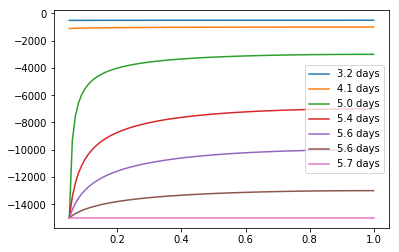

In [70]:
r_root = 0.05   # cm OK
r_out = 1       # cm OK

q_root = 0.5  # [cm/d] OK (0.5 high demand, 0.1 low demand)
q_out = 0 # q_root * (r_root/(2*r_out)) # does not work TODO

h_lim = -15000   # cm OK
h_out = [-500, -1000,  -3000, -7000, -10000, -13000, -15000];   #cm

soil = sand

rho = r_out/r_root
r = np.linspace(r_root, r_out, 100)
q_r_act = np.zeros(len(h_out))

for k in range(len(h_out)):
    
    MFP_nostress = MFP(h_out[k],soil) + (q_root*r_root-q_out*r_out)*(r**2/r_root**2/(2*(1-rho**2))+rho**2/(1-rho**2)*(np.log(r_out/r)-0.5)) + q_out*r_out*np.log(r/r_out)
    MFP_stress = (MFP(h_out[k],soil)+q_out*r_out*np.log(1/rho))*( (r**2/r_root**2 - 1 + 2*rho**2*np.log(r_root/r))/(rho**2 - 1+2*rho**2*np.log(1/rho)) ) + q_out*r_out*np.log(r/r_root)
    
    h_radial = np.zeros(len(r)) 
    wc_radial = np.zeros(len(r))
    
    if np.amin(MFP_nostress)>0: # no stress
        q_r_act[k] = q_root        
        for i in range(len(r)):
            h_radial[i] = h(MFP_nostress[i],soil)
            wc_radial[i] = water_content(h_radial[i],soil)
    else:               # stress
        for i in range(len(r)):      
            if MFP_stress[i]<0:
                print("warning (stress)")
                h_radial[i] = -15000
            else:                    
                h_radial[i] = h(MFP_stress[i],soil)                
            wc_radial[i] = water_content(h_radial[i],soil)   
        
        q_r_act[k] = q_root  # TODO ?
    
    # plots
    V = 2*pi*np.trapz(wc_radial*r,x=r)
    Vi = (r_out**2-r_root**2)*pi*water_content(-100,soil)
    simtime=(Vi - V)/(2*r_root*pi*q_root)
    plt.plot(r,h_radial,label="{:.1f} days".format(simtime))

plt.legend()
plt.show()